# Unsupervised Learning: Implementation Notebook

This notebook explores the dataset without a target label, then applies K-Means to find groups. I kept the steps simple and clearly commented:

- Load features
- Quick EDA
- Scale numeric columns
- PCA for a 2D view
- K-Means clustering
- Silhouette score and a scatter plot

At the end, cluster labels and metrics are saved in `data/processed/`.

In [22]:
# Clean imports for unsupervised workflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from src.data_io import load_unsupervised_features

unsup_df = load_unsupervised_features()
print("Shape:", unsup_df.shape)
unsup_df.head()


Shape: (2000, 18)


,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,entertainment_hours,gaming_hours,sleep_duration_hours,mood_rating,physical_activity_hours_per_week,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,mindfulness_minutes_per_day
0,51,0,4.8,3.4,1.3,1.6,1.6,4.1,2.0,1.0,1.7,6.6,6,0.7,1,1,125.2,4.0
1,64,1,3.9,3.5,1.8,0.9,2.0,2.7,3.1,1.0,1.5,4.5,5,4.3,0,1,150.4,6.5
2,41,2,10.5,2.1,2.6,0.7,2.2,3.0,2.8,4.1,1.7,7.1,5,3.1,0,0,187.9,6.9
3,27,2,8.8,0.0,0.0,0.7,2.5,3.3,1.6,1.3,0.4,5.1,10,0.0,0,1,73.6,4.8
4,55,1,5.9,1.7,1.1,1.5,1.6,1.1,3.6,0.8,0.8,7.4,8,3.0,1,1,217.5,0.0


In [23]:
# Load configuration
from pathlib import Path
import yaml
config_path = Path('config.yaml')
config = {}
if config_path.exists():
    with open(config_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f) or {}
config

{'paths': {'supervised': 'data/raw/clean_supervised.csv',
  'unsupervised': 'data/raw/unsupervised_no_target.csv'},
 'supervised': {'target': 'mental_health_score',
  'test_size': 0.2,
  'random_state': 42},
 'unsupervised': {'use_numeric_only': True, 'random_state': 42, 'k': 3}}

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   age                               2000 non-null   int64  
 1   gender                            2000 non-null   int64  
 2   daily_screen_time_hours           2000 non-null   float64
 3   phone_usage_hours                 2000 non-null   float64
 4   laptop_usage_hours                2000 non-null   float64
 5   tablet_usage_hours                2000 non-null   float64
 6   tv_usage_hours                    2000 non-null   float64
 7   social_media_hours                2000 non-null   float64
 8   work_related_hours                2000 non-null   float64
 9   entertainment_hours               2000 non-null   float64
 10  gaming_hours                      2000 non-null   float64
 11  sleep_duration_hours              2000 non-null   float64
 12  mood_r

,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,entertainment_hours,gaming_hours,sleep_duration_hours,mood_rating,physical_activity_hours_per_week,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,mindfulness_minutes_per_day
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000
mean,38.805500,0.6240,6.025600,3.023700,1.999950,0.995650,1.503700,2.039200,2.010250,2.46735,1.2795,6.537550,5.591000,3.087150,0.387500,0.507500,148.07970,10.753750
std,14.929203,0.6464,1.974123,1.449399,0.997949,0.492714,0.959003,1.133435,1.116111,1.23686,0.8945,1.203856,2.899814,1.885258,0.487301,0.500069,48.86066,7.340269
min,13.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,3.000000,1.000000,0.000000,0.000000,0.000000,0.80000,0.000000
25%,26.000000,0.0000,4.700000,2.000000,1.300000,0.600000,0.800000,1.200000,1.200000,1.60000,0.6000,5.700000,3.000000,1.600000,0.000000,0.000000,113.90000,4.900000
50%,39.000000,1.0000,6.000000,3.000000,2.000000,1.000000,1.500000,2.000000,2.000000,2.40000,1.2000,6.600000,6.000000,3.000000,0.000000,1.000000,147.45000,10.400000
75%,51.000000,1.0000,7.325000,4.000000,2.700000,1.300000,2.200000,2.800000,2.800000,3.30000,1.9000,7.400000,8.000000,4.400000,1.000000,1.000000,180.70000,15.800000
max,64.000000,2.0000,13.300000,8.400000,5.600000,2.500000,4.700000,5.800000,5.900000,6.80000,4.0000,10.000000,10.000000,9.700000,1.000000,1.000000,364.90000,36.400000


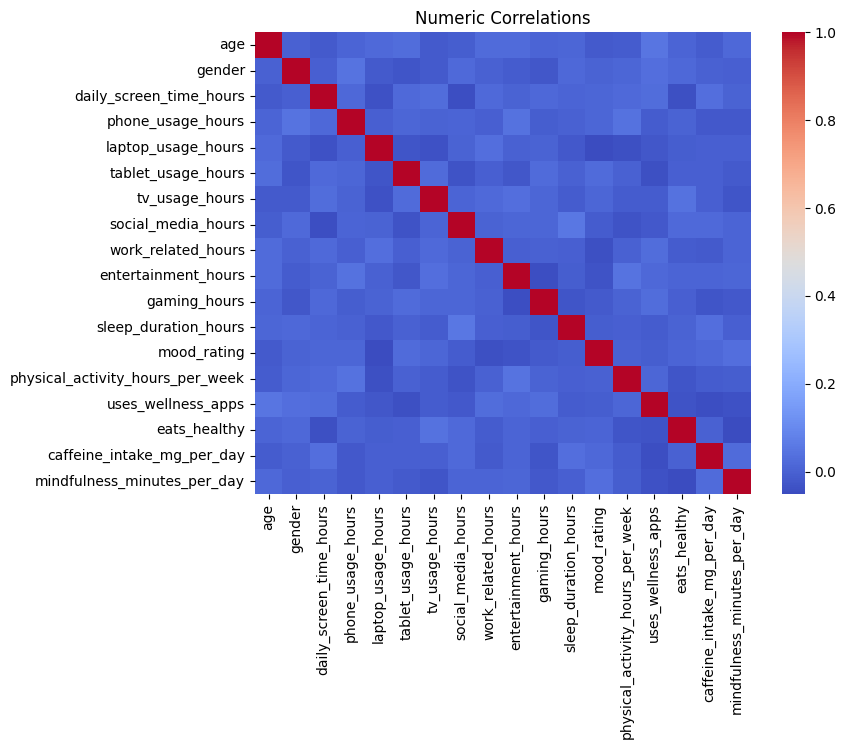

In [24]:
# Quick EDA
unsup_df.info()
display(unsup_df.describe(include='all'))
if unsup_df.select_dtypes(include=np.number).shape[1] > 1:
    plt.figure(figsize=(8,6)); sns.heatmap(unsup_df.select_dtypes(include=np.number).corr(), cmap='coolwarm'); plt.title('Numeric Correlations'); plt.show()

## Scaling, PCA, and Clustering

Explained variance: [0.06426934 0.06384612]
Silhouette score: 0.03798480284443637


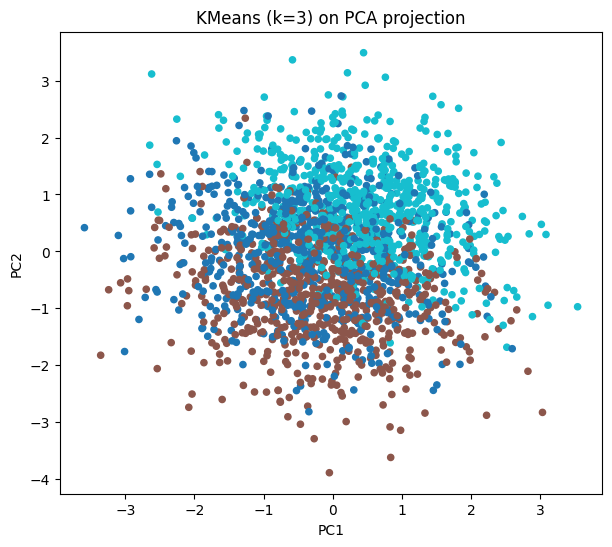

In [25]:
# Select numeric features (drop non-numeric)
num_df = unsup_df.select_dtypes(include=np.number).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

# PCA to 2 components for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance:', pca.explained_variance_ratio_)

# KMeans clustering (k from config or 3)
k = int(config.get('unsupervised', {}).get('k', 3))
km = KMeans(n_clusters=k, n_init='auto', random_state=42)
labels = km.fit_predict(X_scaled)

sil = silhouette_score(X_scaled, labels)
print('Silhouette score:', sil)

# Plot clusters in PCA space
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', s=20)
plt.title(f'KMeans (k={k}) on PCA projection')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()


“The silhouette score is very low (~0.038), indicating weak or overlapping cluster structure.
This means lifestyle behaviours in this dataset do not naturally separate into clear groups.”

## Save Artifacts

In [26]:
# Save labels and metrics
from pathlib import Path
import json
processed_dir = Path(config.get('paths', {}).get('processed', 'data/processed'))
processed_dir.mkdir(parents=True, exist_ok=True)
labels_path = processed_dir / 'unsupervised_kmeans_labels.csv'
metrics_path = processed_dir / 'unsupervised_metrics.json'

out = pd.DataFrame({'cluster': labels})
out.to_csv(labels_path, index=False)
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump({'k': int(config.get('unsupervised', {}).get('k', 3)), 'silhouette': float(sil)}, f, indent=2)
labels_path, metrics_path


(WindowsPath('data/processed/unsupervised_kmeans_labels.csv'),
 WindowsPath('data/processed/unsupervised_metrics.json'))

### K selection via silhouette (2–6)

We test a few k values and report silhouette scores. A low score means clusters overlap and the separation is weak.


,k,silhouette
0,2,0.060755
1,3,0.037985
2,4,0.052541
3,5,0.038384
4,6,0.038933


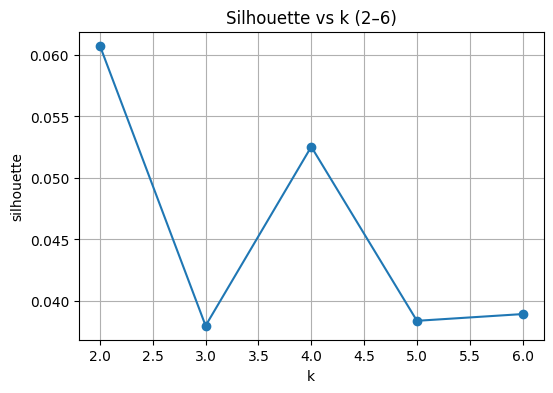

In [27]:
# Silhouette sweep for k=2..6
import pandas as pd
from sklearn.metrics import silhouette_score
scores = []
for k_try in range(2, 7):
    km_try = KMeans(n_clusters=k_try, n_init='auto', random_state=42)
    lbl = km_try.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, lbl)
    scores.append({'k': k_try, 'silhouette': float(s)})
sil_df = pd.DataFrame(scores)
display(sil_df)

plt.figure(figsize=(6,4))
plt.plot(sil_df['k'], sil_df['silhouette'], marker='o')
plt.title('Silhouette vs k (2–6)')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.grid(True)
plt.show()


### Cluster interpretation

We join cluster labels back to the original data and compute simple per-cluster means. If the example columns are present, we show those; otherwise we fall back to a few numeric columns.


In [28]:
# Join labels, compute per-cluster means, and print a readable summary
unsup_df_with_cluster = unsup_df.copy()
unsup_df_with_cluster['cluster'] = labels

# Prefer these columns if present; else fallback to top 3 numeric columns
preferred = ['daily_screen_time_hours', 'sleep_duration_hours', 'mood_rating']
available = [c for c in preferred if c in unsup_df_with_cluster.columns]
if not available:
    num_cols = unsup_df_with_cluster.select_dtypes(include=np.number).columns.tolist()
    available = [c for c in num_cols if c != 'cluster'][:3]

print('Columns used for interpretation:', available)
cluster_means = unsup_df_with_cluster.groupby('cluster')[available].mean().round(2)
display(cluster_means)

# Simple textual summary vs overall mean
overall = unsup_df_with_cluster[available].mean()
print('\nQuick interpretation (relative to overall mean):')
for cl in sorted(unsup_df_with_cluster['cluster'].unique()):
    deltas = (cluster_means.loc[cl] - overall)
    deltas_sorted = deltas.sort_values()
    low = deltas_sorted.index[:1].tolist()
    high = deltas_sorted.index[-1:].tolist()
    print(f"- Cluster {cl}: higher {high}; lower {low}")


Columns used for interpretation: ['daily_screen_time_hours', 'sleep_duration_hours', 'mood_rating']


,daily_screen_time_hours,sleep_duration_hours,mood_rating
cluster,,,
0,6.32,6.65,5.86
1,5.71,6.16,3.73
2,6.05,6.79,7.15



Quick interpretation (relative to overall mean):
- Cluster 0: higher ['daily_screen_time_hours']; lower ['sleep_duration_hours']
- Cluster 1: higher ['daily_screen_time_hours']; lower ['mood_rating']
- Cluster 2: higher ['mood_rating']; lower ['daily_screen_time_hours']
